In [84]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from skimage.morphology import skeletonize
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
import seaborn as sns
from skimage.graph import route_through_array
import networkx as nx

In [81]:
def extract_leaf_regions_with_bboxes_and_bases(
    image_path,
    center_landmarks,
    base_landmarks,
    dilation_iter=5,
    min_area=500
):
    import cv2
    import numpy as np
    from skimage.measure import label, regionprops
    from skimage.morphology import skeletonize
    from scipy.spatial import ConvexHull, distance

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.bilateralFilter(img, 1, 100, 100)

    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inverted = cv2.bitwise_not(thresh)

    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(inverted, kernel, iterations=dilation_iter)

    labeled = label(dilated)
    props = regionprops(labeled)

    landmark_assignments = {}
    for i, (x, y) in enumerate(center_landmarks):
        min_dist = float('inf')
        assigned_label = None
        for region in props:
            if region.area >= min_area:
                cy, cx = region.centroid
                dist = np.hypot(cx - x, cy - y)
                if dist < min_dist:
                    min_dist = dist
                    assigned_label = region.label
        landmark_assignments[i] = assigned_label

    hull_masks = []
    for i, region_idx in landmark_assignments.items():
        if region_idx is None:
            hull_masks.append((None, i, 0))
            continue

        component_mask = (labeled == region_idx).astype(np.uint8)
        coords = np.column_stack(np.where(component_mask > 0))
        if coords.shape[0] < 3:
            hull_masks.append((None, i, 0))
            continue

        hull = ConvexHull(coords)
        hull_pts = coords[hull.vertices]
        hull_mask = np.zeros_like(component_mask)
        cv2.fillConvexPoly(hull_mask, hull_pts[:, [1, 0]], 1)

        area = int(np.sum(hull_mask))
        hull_masks.append((hull_mask, i, area))

    hull_masks.sort(key=lambda x: -x[2])
    final_hull_masks = [None] * len(center_landmarks)
    used_mask = np.zeros_like(img, dtype=bool)

    for hull_mask, idx, _ in hull_masks:
        if hull_mask is None:
            final_hull_masks[idx] = None
            continue
        unique_mask = np.logical_and(hull_mask, ~used_mask)
        used_mask |= unique_mask
        final_hull_masks[idx] = unique_mask.astype(np.uint8)

    outputs = []
    corrected_base_points = []

    for i, mask in enumerate(final_hull_masks):
        if mask is None or np.count_nonzero(mask) == 0:
            print(f"⚠️ Leaf {i}: Mask is empty or missing, skipping.")
            outputs.append((None, None, None, None, i))
            corrected_base_points.append(None)
            continue

        coords = np.column_stack(np.where(mask > 0))
        if coords.shape[0] == 0:
            print(f"⚠️ Leaf {i}: No pixels found in mask.")
            outputs.append((None, None, None, None, i))
            corrected_base_points.append(None)
            continue

        min_row, min_col = coords.min(axis=0)
        max_row, max_col = coords.max(axis=0)
        bbox = (min_row, min_col, max_row, max_col)

        grayscale_crop = img[min_row:max_row+1, min_col:max_col+1] * mask[min_row:max_row+1, min_col:max_col+1]
        threshold_crop = inverted[min_row:max_row+1, min_col:max_col+1] * mask[min_row:max_row+1, min_col:max_col+1]
        mask_crop = mask[min_row:max_row+1, min_col:max_col+1]

        # Translate global base point to local coordinates
        base_x, base_y = base_landmarks[i]
        local_base = np.array([int(round(base_y - min_row)), int(round(base_x - min_col))])

        # Validate and correct base point
        valid_coords = np.column_stack(np.where(threshold_crop > 0))
        if valid_coords.size == 0:
            corrected_base_points.append(None)
        else:
            if (
                0 <= local_base[0] < threshold_crop.shape[0]
                and 0 <= local_base[1] < threshold_crop.shape[1]
                and threshold_crop[local_base[0], local_base[1]] > 0
            ):
                corrected_base = tuple(local_base)
            else:
                dists = np.linalg.norm(valid_coords - local_base, axis=1)
                closest_idx = np.argmin(dists)
                corrected_base = tuple(valid_coords[closest_idx])
            corrected_base_points.append(corrected_base)

        outputs.append((grayscale_crop, threshold_crop, mask_crop, bbox, i))

    return outputs, corrected_base_points

def visualize_thresholded_leaves_with_hulls(image_path, leaf_outputs, alpha_thresh=0.4):
    """
    Displays the thresholded fronds and their convex hulls on the original image.
    
    Parameters:
    - image_path: str, path to the original grayscale image.
    - leaf_outputs: list of tuples from extract_leaf_regions_with_bboxes().
    - alpha_thresh: float, transparency level for overlaying thresholded pixels.
    """
    # Load original grayscale image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    overlay = np.zeros_like(img_rgb, dtype=np.uint8)

    for output in leaf_outputs:
        threshold_crop, mask_crop, bbox = output[1], output[2], output[3]
        if threshold_crop is None or mask_crop is None or bbox is None:
            continue

        min_row, min_col, max_row, max_col = bbox

        # Overlay the thresholded region (in magenta)
        overlay_crop = overlay[min_row:max_row+1, min_col:max_col+1]
        magenta = np.zeros_like(overlay_crop)
        magenta[..., 0] = threshold_crop  # Red
        magenta[..., 2] = threshold_crop  # Blue
        overlay[min_row:max_row+1, min_col:max_col+1] = np.maximum(overlay_crop, magenta)

        # Overlay the convex hull (in green)
        contours, _ = cv2.findContours(mask_crop.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            contour[:, 0, 1] += min_row  # row
            contour[:, 0, 0] += min_col  # col
            cv2.drawContours(img_rgb, [contour], -1, (0, 255, 0), thickness=2)

    # Combine original and overlay
    blended = cv2.addWeighted(img_rgb, 1.0, overlay, alpha_thresh, 0)

    # Show result
    plt.figure(figsize=(10, 10))
    plt.imshow(blended)
    plt.axis('off')
    plt.title("Thresholded Leaves with Convex Hulls")
    plt.show()

def compute_skeleton_guided_cost(thresh_inverted, skeleton, distance_multiplier=1.0, visualize=False):
    """
    Create a cost array where foreground pixels (0s in inverted threshold)
    are weighted by distance to the nearest skeleton pixel. Background pixels (255)
    remain high-cost.

    Parameters:
    - thresh_inverted: np.ndarray, uint8, 0 = vein, 255 = background
    - skeleton: boolean array, True = skeleton pixel
    - distance_multiplier: float, scale for distance transform in foreground
    - visualize: bool, optionally shows a debug visualization

    Returns:
    - cost_array: np.ndarray, float32, same shape as input
    """

    # Define mask of foreground (veins)
    vein_mask = thresh_inverted == 0

    # Distance to nearest skeleton pixel
    dist_to_skeleton = distance_transform_edt(~skeleton)

    # Initialize cost array
    cost_array = np.full_like(thresh_inverted, fill_value=255, dtype=np.float32)

    # Assign cost in the vein region proportional to distance to skeleton
    cost_array[vein_mask] = dist_to_skeleton[vein_mask] * distance_multiplier

    if visualize:
        # Stretching for visualization purposes only
        vis_array = cost_array.copy()
        vis_array[~vein_mask] = np.nan  # Mask background for better contrast
        plt.imshow(vis_array, cmap='inferno')
        plt.title(f"Skeleton-guided cost map (mult={distance_multiplier})")
        plt.colorbar(label='Cost')
        plt.show()

    return cost_array

def compute_mcp_paths(cost_array, skeleton, base_point):
    """
    Compute minimum cost paths from each skeleton pixel to the base point.
    
    Parameters:
    - cost_array: 2D np.ndarray with precomputed costs (higher = less preferred)
    - skeleton: 2D np.ndarray of bools (True = skeleton pixels)
    - base_point: tuple (row, col) in image coordinates

    Returns:
    - all_paths: list of paths (each a list of (row, col) tuples)
    - costs: list of path costs (floats)
    - frequency_map: np.ndarray same shape as cost_array, counts how often each pixel is part of a path
    """
    skeleton_pts = np.column_stack(np.where(skeleton))
    all_paths = []
    costs = []
    frequency_map = np.zeros_like(cost_array, dtype=np.uint32)

    for i, start in enumerate(skeleton_pts):
        try:
            path, cost = route_through_array(
                cost_array, 
                start=tuple(start), 
                end=tuple(base_point), 
                fully_connected=True
            )
            for r, c in path:
                frequency_map[r, c] += 1
            all_paths.append(path)
            costs.append(cost)
        except Exception:
            continue  # Skip if no path found

    return all_paths, costs, frequency_map

def compute_frequency_map(cost_array, skeleton, base_point):
    """
    Compute a frequency map by calculating minimum cost paths from each skeleton pixel to a base point.

    Parameters:
    - cost_array: 2D array of traversal costs.
    - skeleton: Boolean 2D array indicating skeleton pixels (True = part of skeleton).
    - base_point: Tuple (row, col) indicating the base point for MCP calculations.

    Returns:
    - freq_map: 2D array where each pixel's value is the number of times it was traversed in all paths.
    """
    freq_map = np.zeros_like(cost_array, dtype=np.uint32)
    skeleton_coords = np.column_stack(np.where(skeleton))

    for start in skeleton_coords:
        try:
            path, _ = route_through_array(cost_array, start=start, end=base_point, fully_connected=True)
            for r, c in path:
                freq_map[r, c] += 1
        except Exception:
            continue  # Skip if path not found

    return freq_map

def freq_map_to_graph(freq_map, retain_largest_component=True, weighted=False):
    """
    Converts a frequency map into a NetworkX graph with embedded spatial coordinates.

    Parameters:
    - freq_map: 2D numpy array with non-zero values indicating graph nodes.
    - retain_largest_component: Whether to keep only the largest connected component.
    - weighted: If True, edges are weighted by the average frequency of the connected pixels.

    Returns:
    - G: A NetworkX graph with nodes at (row, col) positions and optional edge weights.
    """
    nodes = np.argwhere(freq_map > 0)
    if nodes.size == 0:
        raise ValueError("No valid nodes found in the frequency map.")

    G = nx.Graph()
    for r, c in nodes:
        G.add_node((r, c), pos=(r, c), freq=int(freq_map[r, c]))

    # 8-connectivity
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               ( 0, -1),          ( 0, 1),
               ( 1, -1), ( 1, 0), ( 1, 1)]

    for r, c in nodes:
        for dr, dc in offsets:
            nr, nc = r + dr, c + dc
            if (0 <= nr < freq_map.shape[0]) and (0 <= nc < freq_map.shape[1]):
                if freq_map[nr, nc] > 0:
                    if weighted:
                        weight = (freq_map[r, c] + freq_map[nr, nc]) / 2
                        G.add_edge((r, c), (nr, nc), weight=weight)
                    else:
                        G.add_edge((r, c), (nr, nc))

    if retain_largest_component:
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    return G



In [61]:
image_path = "test.jp2"
center_landmarks = np.loadtxt("middle_pts.txt") # landmarks of middle of frond
base_landmarks = np.loadtxt("base_pts.txt") # landmarks at base of frond
dilations = 5 # number of dilations to select a frond
minimum_area = 500 # minimum pixel area to select frond
distance_multiply = 30 # the multiplier of the distance of threshold pixels from the skeleton

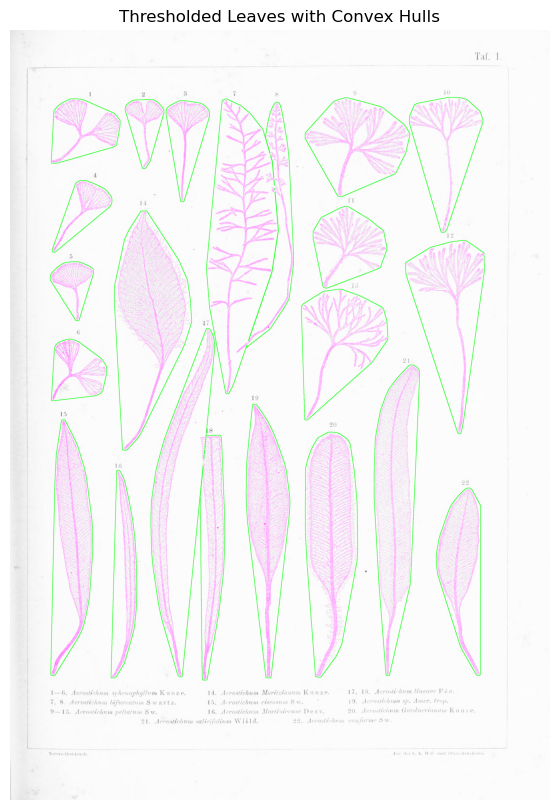

In [85]:
# leaf_outputs: grayscale, thresholded, mask, bbox, idx 
leaf_outputs, corrected_bases = extract_leaf_regions_with_bboxes_and_bases(image_path, 
                                                          center_landmarks,
                                                          base_landmarks,
                                                          dilation_iter=dilations,
                                                          min_area=minimum_area)

# check the results of segmented fronds
visualize_thresholded_leaves_with_hulls(image_path, leaf_outputs, alpha_thresh=1.0)

In [ ]:
for i in range(len(leaf_outputs)):

    print(i)

    # retrieve grayscale image, thresholded image, the mask, bounding box, and index
    grayscale, thresholded, mask, bbox, index = leaf_outputs[i]
    
    # retrieve the corrected base point of the frond
    base_pt = corrected_bases[i]
    
    # normalize the image
    norm_image = thresholded/255 # normalize image
    
    # get the skeleton
    skeleton = skeletonize(norm_image) # skeletonize image
    
    # invert the image
    inv_img = cv2.bitwise_not(thresholded) # invert image
    
    # calculate the cost array
    cost = compute_skeleton_guided_cost(inv_img, skeleton, distance_multiplier=distance_multiply)
    
    # check histogram of cost values if needed
    #sns.histplot(cost, legend=False)
    
    # CALCULATE FREQUENCY MAP
    freq_map = compute_frequency_map(
        cost_array=cost,
        skeleton=skeleton,
        base_point=(base_pt[0], base_pt[1])
    )
    
    # CREATE NETWORKX GRAPH
    G = freq_map_to_graph(freq_map, retain_largest_component=True, weighted=False)
    
    # MAKE AND SAVE PLOTS
    plt.figure(figsize=(np.shape(freq_map)[1]/100,np.shape(freq_map)[0]/100))
    plt.imshow(freq_map, cmap="RdPu", vmin=0, vmax=1)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("plots/freq_"+str(i)+".png")
    plt.close()
    
    # Extract the positions from the graph (these are pixel coordinates)
    pos = nx.get_node_attributes(G, 'pos')
    # Plot with correct spatial layout
    nx.draw(G, pos=pos, node_size=0, edge_color='k', width=1)
    plt.gca().invert_yaxis()  # Optional: to match image orientation
    plt.axis('equal')
    plt.savefig("plots/graph_"+str(i)+".png")
    plt.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
